### Comparison of `Vanilla XGBoost`, `Random-Search Tuned XGBoost` and `Self-Pace-Ensemble boosted XGBoost`

## The Method

1. Prepare data & Partition the data into 80-20 train-test split
2. Define Models & Parameters
3. Perform Cross-Validation on the training data
3. (Re)Train the models on the training data, either vanilla model or with best hyperparameters
4. Evaluate the (re)trained models on the test data
5. Final evaluation of the models

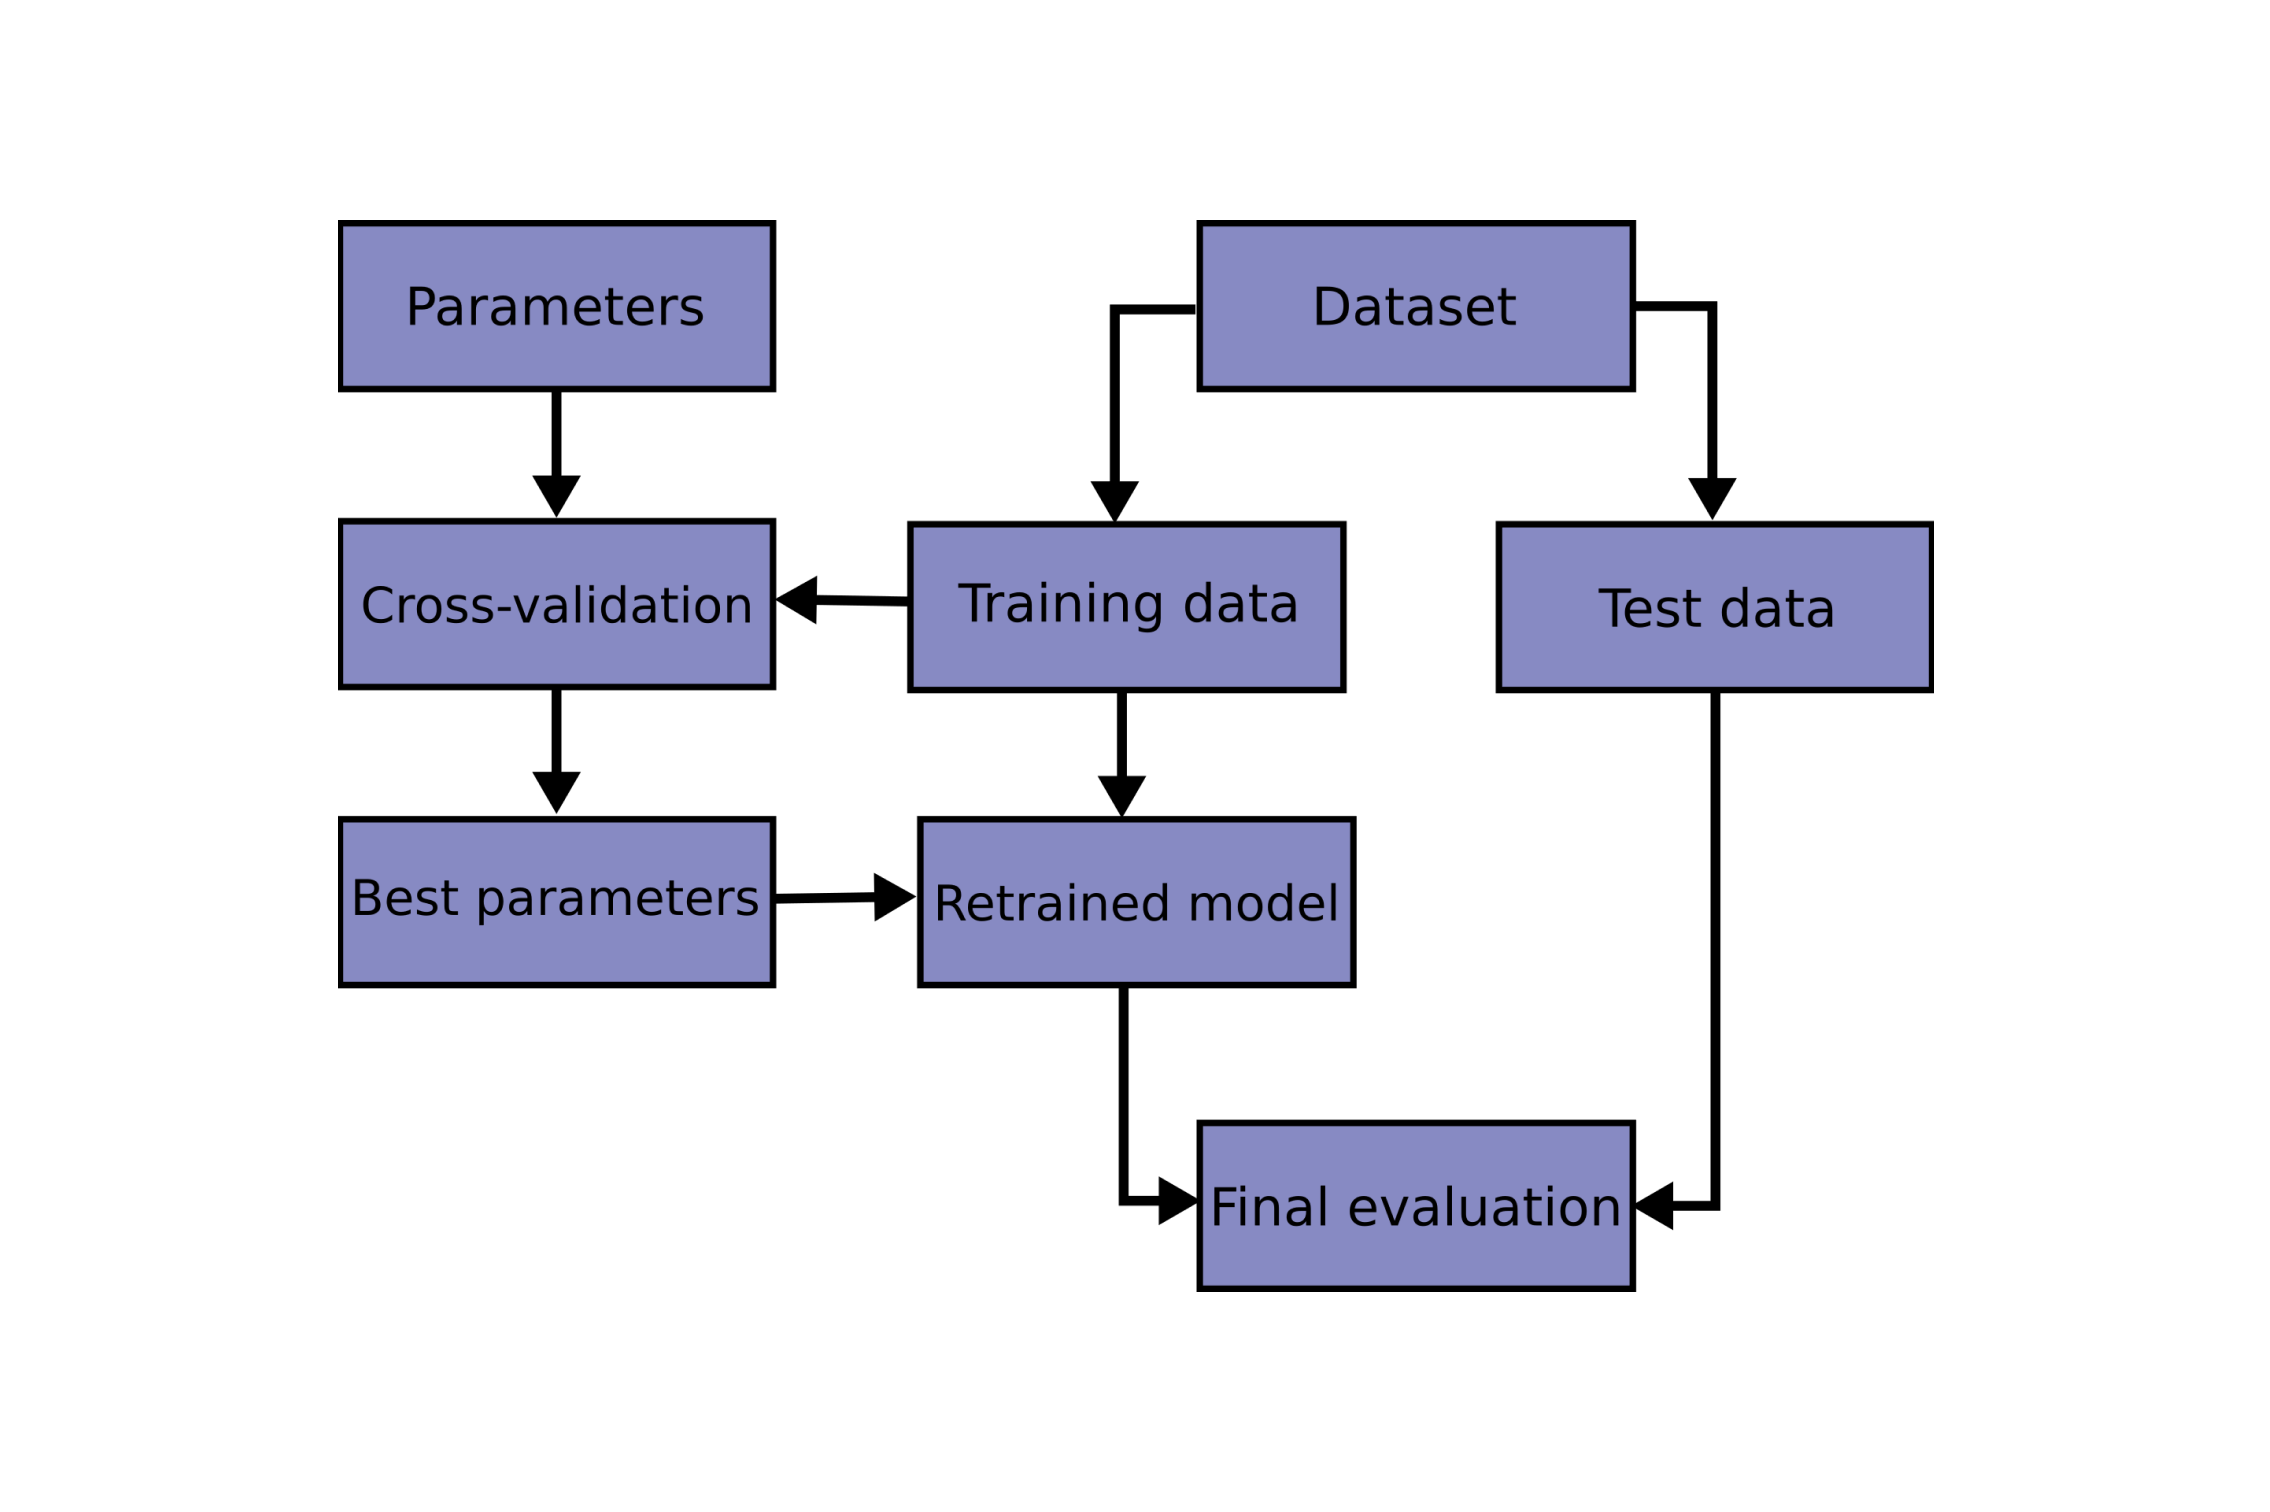

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, classification_report, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import joblib
from scipy.stats import mannwhitneyu
from pprint import pprint
from time import time

from xgboost import XGBClassifier
from imbens.ensemble import SelfPacedEnsembleClassifier as SPEClassifier

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
CROSS_VAL_SPLITS = 5

### 1. Prepare data & Partition the data into 80-20 train-test split

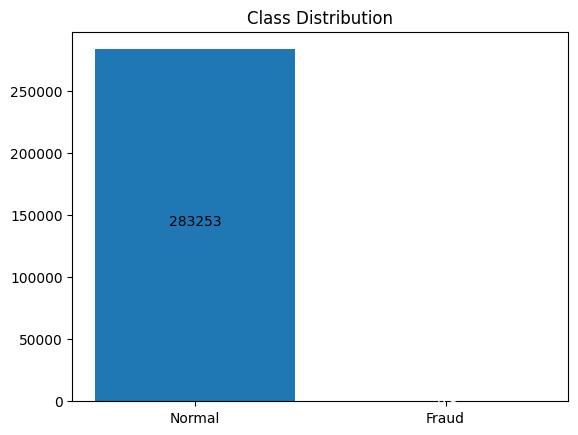

In [2]:
# Importing the dataset
path_to_data = '../data/creditcard/creditcard.csv'

# col names data set
col_names = [
    "Time","V1","V2","V3","V4","V5","V6","V7","V8","V9","V10","V11","V12","V13","V14","V15","V16","V17","V18","V19","V20","V21","V22","V23","V24","V25","V26","V27","V28","Amount","label"
] # V1-V28 are PCA transformed features, but are anonymized due to confidentiality reasons and are not interpretable
# Label is 1 if fraud, 0 otherwise

# read full data set
data = pd.read_csv(path_to_data, names=col_names, index_col=0, header=0)

# drop duplicates  & time column
data.drop_duplicates(inplace=True)
data.drop("Time", axis=1, inplace=True)

# Split data sets into X, y respectively
X = data.drop("label", axis=1)
y = data["label"]

# Stratified 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

# Visualize class imbalance
plt.bar(["Normal", "Fraud"], data["label"].value_counts())
total = len(data)
fraud_percentage = (data["label"].value_counts()[1])
normal_percentage = (data["label"].value_counts()[0])

plt.text(0, data["label"].value_counts()[0] / 2, f'{normal_percentage}', ha='center', color='black')
plt.text(1, data["label"].value_counts()[1] / 2, f'{fraud_percentage}', ha='center', color='white')
plt.title("Class Distribution")
plt.show()

### 2. Define models and parameters

In [5]:
# Vanilla XGBoost
vanilla_xgb_pipeline = Pipeline([
    ('xgb', XGBClassifier())  # Default XGBoost classifier 
])

# RandomizedSearchCV XGBoost
random_search_xgb_pipeline = Pipeline([
    ('rs_tuned_xgb', XGBClassifier()) # XGBoost as base learner
])

# Self-paced ensemble classifier 
spe_boosted_xgb_pipeline = Pipeline([
    ('spe_xgb', SPEClassifier(
		estimator=XGBClassifier(), # XGBoost as base learner
    )) 
])

# Random search parameter space, prefix parameters with 'rs_tuned_xgb'
parameter_grid = {
    'rs_tuned_xgb__objective': ['binary:logistic'],
    'rs_tuned_xgb__max_leaves': [0, 2**6, 2**8],
    'rs_tuned_xgb__learning_rate': [0.002, 0.1, 0.3],
    'rs_tuned_xgb__gamma': [0.1, 0.3],
    'rs_tuned_xgb__max_depth': [6, 12, 20, 25],
    'rs_tuned_xgb__subsample': [0.4, 0.7, 1],
    'rs_tuned_xgb__colsample_bytree': [0.4, 0.5, 0.7, 1],
    'rs_tuned_xgb__reg_alpha': [0, 0.9, 1],
    'rs_tuned_xgb__reg_lambda': [0.3, 1],
    'rs_tuned_xgb__eval_metric': ['aucpr'],
    'rs_tuned_xgb__scale_pos_weight': [1, 2, 4, 580],
    'rs_tuned_xgb__n_estimators': [100, 170, 500, 700, 1000, 2000, 5000],
    'rs_tuned_xgb__booster': ['gbtree'],
    'rs_tuned_xgb__tree_method': ['hist'],
}

# Define multimetric scoring
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Randomized search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=random_search_xgb_pipeline,
    param_distributions=parameter_grid,
    n_iter=10,
    scoring=scoring, # Multimetric scoring
    refit='f1', # Refit on F1 score. Other metrics are for reporting purposes. F1 will be used to select the best model.
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), # 5-fold stratified cross-validation
    verbose=1,
    n_jobs=-1, # Use all available cores
    random_state=RANDOM_STATE
)

### 3. Perform Cross-Validation on the training data

In [6]:
# Run random search on XGBoost and fit to training data
print("\nRunning RandomizedSearchCV for XGBoost...")
print("Hyperparameters to be evaluated:\n")
pprint(parameter_grid)

t0 = time()
random_search.fit(X_train, y_train)
print(f"\nRandomizedSearchCV took {time() - t0:.2f} seconds ({(time() - t0) / 60:.2f} minutes)")

print("\nBest parameters combination found:")
best_parameters = random_search.best_estimator_.get_params()
for param_name in sorted(parameter_grid.keys()):
    print(f"{param_name}: {best_parameters[param_name]}")

# Best estimator from RandomizedSearchCV
best_xgb_model = random_search.best_estimator_

# save model
joblib.dump(best_xgb_model, 'saved/best_xgb_model.pkl')


Running RandomizedSearchCV for XGBoost...
Hyperparameters to be evaluated:

{'rs_tuned_xgb__booster': ['gbtree'],
 'rs_tuned_xgb__colsample_bytree': [0.4, 0.5, 0.7, 1],
 'rs_tuned_xgb__eval_metric': ['aucpr'],
 'rs_tuned_xgb__gamma': [0.1, 0.3],
 'rs_tuned_xgb__learning_rate': [0.002, 0.1, 0.3],
 'rs_tuned_xgb__max_depth': [6, 12, 20, 25],
 'rs_tuned_xgb__max_leaves': [0, 64, 256],
 'rs_tuned_xgb__n_estimators': [100, 170, 500, 700, 1000, 2000, 5000],
 'rs_tuned_xgb__objective': ['binary:logistic'],
 'rs_tuned_xgb__reg_alpha': [0, 0.9, 1],
 'rs_tuned_xgb__reg_lambda': [0.3, 1],
 'rs_tuned_xgb__scale_pos_weight': [1, 2, 4, 580],
 'rs_tuned_xgb__subsample': [0.4, 0.7, 1],
 'rs_tuned_xgb__tree_method': ['hist']}
Fitting 5 folds for each of 10 candidates, totalling 50 fits

RandomizedSearchCV took 146.72 seconds (2.45 minutes)

Best parameters combination found:
rs_tuned_xgb__booster: gbtree
rs_tuned_xgb__colsample_bytree: 0.7
rs_tuned_xgb__eval_metric: aucpr
rs_tuned_xgb__gamma: 0.1
rs_t

['saved/best_xgb_model.pkl']

In [7]:
# Get the index of the best combination found by RandomizedSearchCV
best_index = random_search.best_index_

# Extract mean and std for each metric from the best estimator
f1_mean = random_search.cv_results_['mean_test_f1'][best_index]
f1_std = random_search.cv_results_['std_test_f1'][best_index]

precision_mean = random_search.cv_results_['mean_test_precision'][best_index]
precision_std = random_search.cv_results_['std_test_precision'][best_index]

recall_mean = random_search.cv_results_['mean_test_recall'][best_index]
recall_std = random_search.cv_results_['std_test_recall'][best_index]

# Display results with mean ± std deviation format
print("\nCross-Validation Results:")
print(f"F1 Score: {f1_mean:.4f} ± {f1_std:.4f}")
print(f"Precision: {precision_mean:.4f} ± {precision_std:.4f}")
print(f"Recall: {recall_mean:.4f} ± {recall_std:.4f}")


Cross-Validation Results:
F1 Score: 0.8697 ± 0.0280
Precision: 0.9440 ± 0.0197
Recall: 0.8067 ± 0.0372


In [8]:
# Define scoring metrics
scoring = {
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# 5-fold cross-validation for Vanilla XGBoost
print(f"{CROSS_VAL_SPLITS}-fold cross-validation for vanilla XGBoost:")

vanilla_xgb_scores = cross_validate(
    vanilla_xgb_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
vanilla_xgb_scores_df = pd.DataFrame(vanilla_xgb_scores)

# Print mean ± standard deviation of scores
print("\nVanilla XGBoost:")
for metric in scoring.keys():
    mean_score = vanilla_xgb_scores_df[f'test_{metric}'].mean()
    std_score = vanilla_xgb_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")


# 5-fold cross-validation for Self-paced ensemble classifier
print(f"\n{CROSS_VAL_SPLITS}-fold cross-validation for Vanilla SPE XGBoost:")

spe_boosted_xgb_scores = cross_validate(
    spe_boosted_xgb_pipeline, X_train, y_train, 
    cv=StratifiedKFold(n_splits=CROSS_VAL_SPLITS), scoring=scoring, n_jobs=-1
)
spe_boosted_xgb_scores_df = pd.DataFrame(spe_boosted_xgb_scores)

print("\nSelf-paced ensemble classifier:")
for metric in scoring.keys():
    mean_score = spe_boosted_xgb_scores_df[f'test_{metric}'].mean()
    std_score = spe_boosted_xgb_scores_df[f'test_{metric}'].std()
    print(f"{metric}: {mean_score:.4f} ± {std_score:.4f}")

5-fold cross-validation for vanilla XGBoost:

Vanilla XGBoost:
f1: 0.8730 ± 0.0302
precision: 0.9559 ± 0.0236
recall: 0.8040 ± 0.0423

5-fold cross-validation for Vanilla SPE XGBoost:

Self-paced ensemble classifier:
f1: 0.8727 ± 0.0329
precision: 0.9342 ± 0.0316
recall: 0.8199 ± 0.0476


### 4. (Re)Train the models on the training data, either vanilla model or with best hyperparameters

In [9]:
# train vanilla xgb
vanilla_xgb_pipeline.fit(X_train, y_train)

# train spe xgb
spe_boosted_xgb_pipeline.fit(X_train, y_train)

# retrain best xgb model on full training set
best_xgb_model.fit(X_train, y_train)

Pipeline(steps=[('rs_tuned_xgb',
                 XGBClassifier(base_score=None, booster='gbtree',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=0.7,
                               device=None, early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='aucpr',
                               feature_types=None, gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=12, max_leaves=256,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=1000, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

### 5. Final evaluation of the models

Vanilla XGBoost
F-1 Score: 0.8452
Precision: 0.9726
Recall: 0.7474

SPE XGBoost
F-1 Score: 0.8402
Precision: 0.9595
Recall: 0.7474

Best XGBoost (RandomSearchCV)
F-1 Score: 0.8452
Precision: 0.9726
Recall: 0.7474


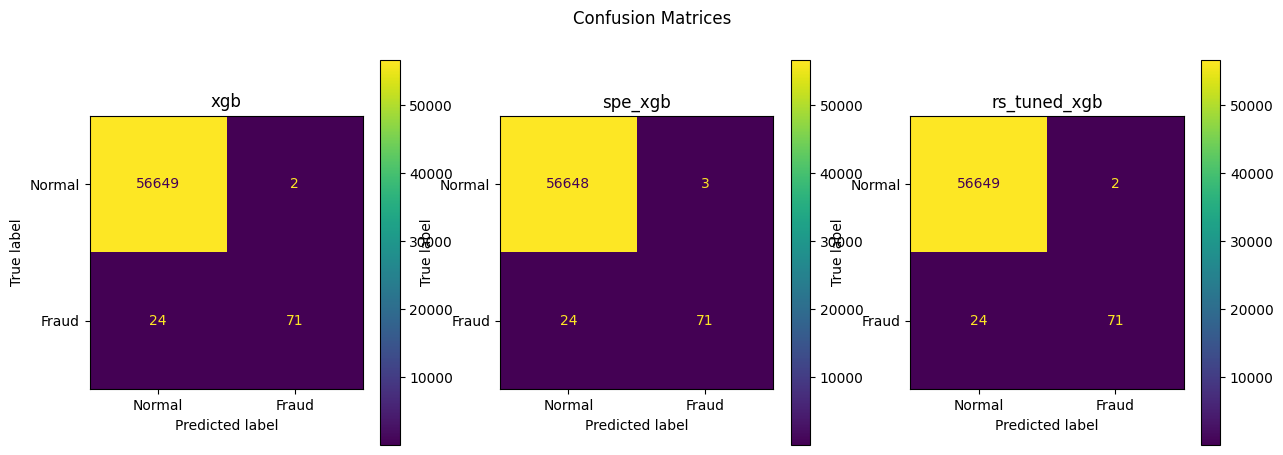

In [10]:
# evaluate each model now on test set on f1, prec, recall and plot confusion matrix for each

# Vanilla XGBoost
y_test_pred = vanilla_xgb_pipeline.predict(X_test)
print("Vanilla XGBoost")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# SPE XGBoost
y_test_pred = spe_boosted_xgb_pipeline.predict(X_test)
print("\nSPE XGBoost")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Best XGBoost
y_test_pred = best_xgb_model.predict(X_test)
print("\nBest XGBoost (RandomSearchCV)")
print(f"F-1 Score: {f1_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Plot confusion matrix for each model
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Confusion Matrices")
for i, model in enumerate([vanilla_xgb_pipeline, spe_boosted_xgb_pipeline, best_xgb_model]):
	y_test_pred = model.predict(X_test)
	cm = confusion_matrix(y_test, y_test_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Fraud"])
	disp.plot(ax=axs[i])
	axs[i].set_title(model.steps[0][0])
plt.show()
